In [26]:
# Step 1: Import libraries and load data
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn import metrics

# Load completed and in-progress datasets
df_completed = pd.read_excel("completed.xlsx")
df_inprogress = pd.read_excel("inprogress.xlsx")

print("Completed data shape:", df_completed.shape)
print("In-progress data shape:", df_inprogress.shape)


Completed data shape: (984, 11)
In-progress data shape: (201, 10)


In [27]:
# Step 2: Select features and target for ActualCost prediction

# According to your correlation analysis, use only these features:
feature_cols = ["Budget", "EstimatedCost", "ActualDuration"]

# Target is now ActualCost
target = "ActualCost"

# Prepare feature matrices and target vector for completed and in-progress projects
X_completed = df_completed[feature_cols].copy()
y_completed = df_completed[target].copy()

X_inprog = df_inprogress[feature_cols].copy()

print("Completed features shape:", X_completed.shape)
print("Completed target shape:", y_completed.shape)
print("In-progress features shape:", X_inprog.shape)


Completed features shape: (984, 3)
Completed target shape: (984,)
In-progress features shape: (201, 3)


In [28]:
# Step 3: Custom train/validation split (same logic as before)

n = len(df_completed)
test_idx = list(range(2, n, 5))       # every 5th starting from 3rd index
train_idx = [i for i in range(n) if i not in test_idx]

X_train = X_completed.iloc[train_idx]
y_train = y_completed.iloc[train_idx]

X_test = X_completed.iloc[test_idx]
y_test = y_completed.iloc[test_idx]

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_test.shape[0]}")


Training set size: 787
Validation set size: 197


In [29]:
#--------------- neural network --------------

In [30]:
pip install tensorflow


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
# Step 1: Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping


In [32]:
# Step 2: Load your data (same as before)
df_completed = pd.read_excel("completed.xlsx")
df_inprogress = pd.read_excel("inprogress.xlsx")

feature_cols = ["Budget", "EstimatedCost", "ActualDuration" ]
target = "ActualCost"

X_completed = df_completed[feature_cols].values
y_completed = df_completed[target].values

X_inprog = df_inprogress[feature_cols].values


In [33]:
# Step 3: Custom train/validation split (same logic)
n = len(df_completed)
test_idx = list(range(2, n, 5))
train_idx = [i for i in range(n) if i not in test_idx]

X_train = X_completed[train_idx]
y_train = y_completed[train_idx]
X_test = X_completed[test_idx]
y_test = y_completed[test_idx]

print(f"Train samples: {X_train.shape[0]}, Validation samples: {X_test.shape[0]}")


Train samples: 787, Validation samples: 197


In [34]:
# Step 4: Scale the features (important for NN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_inprog_scaled = scaler.transform(X_inprog)


In [35]:
# Step 5: Define the neural network model

def build_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1)  # Output layer for regression (single value)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_model()
model.summary()


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,369 (9.25 KB)

 Trainable params: 2,369 (9.25 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Step 6: Train the model with early stopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 83890159616.0000 - mae: 210948.1250 - val_loss: 96212819968.0000 - val_mae: 143608.0156
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 82913861632.0000 - mae: 203083.2500 - val_loss: 96209010688.0000 - val_mae: 143604.5312
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 81453375488.0000 - mae: 203575.9688 - val_loss: 96201351168.0000 - val_mae: 143597.7500
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 86875586560.0000 - mae: 216312.5781 - val_loss: 96186589184.0000 - val_mae: 143584.8125
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 82270216192.0000 - mae: 203760.7812 - val_loss: 96160317440.0000 - val_mae: 143562.1875
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 79076802560.0000 - mae: 202004.9531 - val_loss: 96119013376.0000 - val_mae: 143527.0000
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 81853980672.0000 - mae: 207500.6406 - val_loss: 96059686912

In [37]:
# Step 7: Evaluate on validation set

y_pred = model.predict(X_test_scaled).flatten()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"Validation MSE: {mse:.2f}")
print(f"Validation MAE: {mae:.2f}")
print(f"Validation MAPE: {mape:.2f}%")
print(f"Validation R²: {r2:.3f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Validation MSE: 27817652224.00
Validation MAE: 86723.25
Validation MAPE: 166.74%
Validation R²: 0.632


In [38]:
# Step 8: Retrain model on full completed dataset

X_completed_scaled = scaler.fit_transform(X_completed)  # Refit scaler on full data

model_full = build_model()

early_stop_full = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model_full.fit(
    X_completed_scaled, y_completed,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop_full],
    verbose=1
)


Epoch 1/100


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 86814515200.0000 - mae: 194765.6719   
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 83376029696.0000 - mae: 193785.4062 
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 84951220224.0000 - mae: 196474.3281 
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 83223879680.0000 - mae: 190721.3594 
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 95328772096.0000 - mae: 199117.1094 
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 81526071296.0000 - mae: 188388.8594 
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 96121061376.0000 - mae: 197543.0938 
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 89754214400.0000 - mae: 196492.5781 
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 79904030720.0000 - mae: 193354.8594 
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 78674477056.0000 - mae: 186491.2500 
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/st

In [39]:
# Step 9: Predict ActualCost for in-progress projects

X_inprog_scaled = scaler.transform(X_inprog)  # scale in-progress features

inprog_preds = model_full.predict(X_inprog_scaled).flatten()

df_inprogress["PredictedActualCost_NN"] = inprog_preds

print("Sample predictions for in-progress projects:")
display(df_inprogress.head())


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Sample predictions for in-progress projects:


,Identifier,District,PlannedDuration,Budget,EstimatedCost,ActualDuration,PC1,PC2,PC3,PC4,PredictedActualCost_NN
0,KBDD,23,160,60930,3995,147.805685,0.738653,0.476695,0.465872,0.862702,30671.896484
1,KAYT,23,155,64283,41240,150.351263,1.985520,0.090806,0.667018,0.974323,34633.117188
2,K411,21,163,52748,49376,149.779677,8.918068,0.195586,0.176593,1.336228,34086.789062
3,Q090,27,169,102190,146069,160.301816,-17.758897,1.202303,-0.115135,-2.506692,49154.617188
4,X655,7,163,188750,284485,168.273067,-6.085039,0.222881,0.222080,0.459376,67669.976562


=== Error Metrics for Cost Prediction ===
MAE:   52390.40
MAPE:  26.39%
R²:    0.789


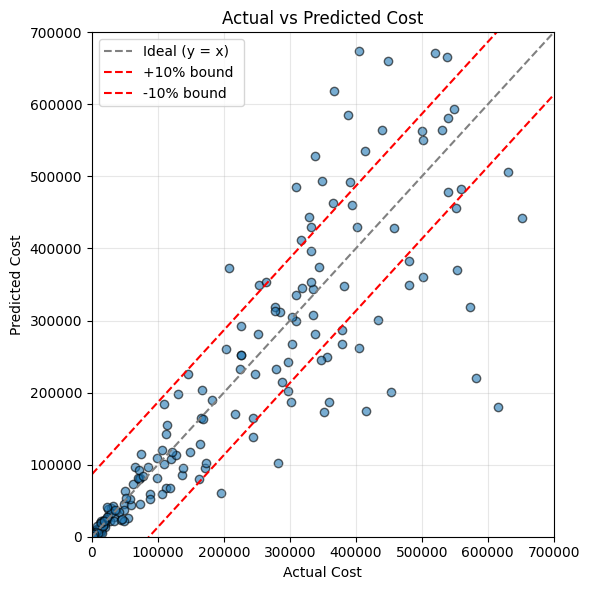


=== ±10% Band Counts for Cost ===
Points within ±10%: 154 / 201
Points outside ±10%: 47 / 201


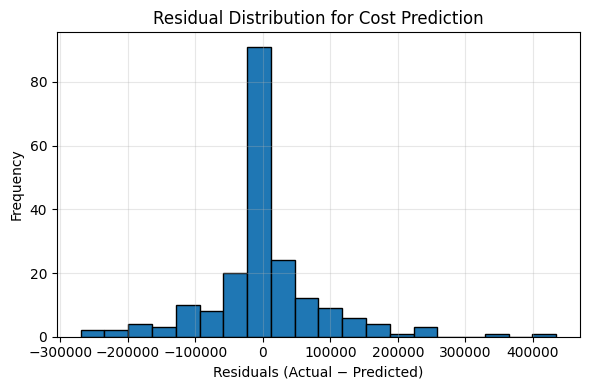

In [40]:

# Step 1: Load the Excel file
file_path = "inprogresscost.xlsx"  # Ensure this path is correct
df = pd.read_excel(file_path)

# Step 2: Extract true and predicted cost arrays
y_true = df["ActualCost"].values
y_pred = df["ActualCostPredicted"].values

# Step 3: Compute evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
r2 = r2_score(y_true, y_pred)

print("=== Error Metrics for Cost Prediction ===")
print(f"MAE:   {mae:.2f}")
print(f"MAPE:  {mape:.2f}%")
print(f"R²:    {r2:.3f}")

# Step 4: Scatter plot (Actual vs. Predicted) with ±10% bounds
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.6, edgecolor="black")

# Determine plotting limits based on data range
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
lims = [0, 700000]
# Maintain axis limits (you can adjust these as needed)
# Now explicitly limit both axes:
plt.xlim(0, 800000)
plt.ylim(0, 800000)

# Plot the 45° “ideal” line (y = x)
plt.plot(lims, lims, "--", color="gray", label="Ideal (y = x)")

# Compute ±10% offset using the same range
delta = 0.10 * (max_val - min_val)
upper = [l + delta for l in lims]
lower = [l - delta for l in lims]

# Plot ±10% bounds
plt.plot(lims, upper, "--", color="red", label="+10% bound ")
plt.plot(lims, lower, "--", color="red", label="-10% bound")

# Fix axes to cover full [min_val, max_val]
plt.xlim(lims)
plt.ylim(lims)

plt.xlabel("Actual Cost")
plt.ylabel("Predicted Cost")
plt.title("Actual vs Predicted Cost")
plt.legend(loc="upper left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Step 5: Count points within ±10% of actual
in_band = (y_pred >= (y_true - delta)) & (y_pred <= (y_true + delta))
count_in = in_band.sum()
count_out = len(y_true) - count_in

print("\n=== ±10% Band Counts for Cost ===")
print(f"Points within ±10%: {count_in} / {len(y_true)}")
print(f"Points outside ±10%: {count_out} / {len(y_true)}")

# Step 6: Plot residual distribution histogram
residuals = y_true - y_pred
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=20, edgecolor="black")
plt.xlabel("Residuals (Actual − Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Distribution for Cost Prediction")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [41]:
# --------------DNN-----------------

In [42]:
# Step 1: Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping


In [43]:
# Step 2: Load data and prepare features/target
df_completed = pd.read_excel("completed.xlsx")
df_inprogress = pd.read_excel("inprogress.xlsx")

feature_cols = ["Budget", "EstimatedCost", "ActualDuration"]
target = "ActualCost"

X_completed = df_completed[feature_cols].values
y_completed = df_completed[target].values
X_inprog = df_inprogress[feature_cols].values


In [44]:
# Step 3: Custom train/validation split
n = len(df_completed)
test_idx = list(range(2, n, 5))
train_idx = [i for i in range(n) if i not in test_idx]

X_train = X_completed[train_idx]
y_train = y_completed[train_idx]
X_test = X_completed[test_idx]
y_test = y_completed[test_idx]

print(f"Train samples: {X_train.shape[0]}, Validation samples: {X_test.shape[0]}")


Train samples: 787, Validation samples: 197


In [45]:
# Step 4: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_inprog_scaled = scaler.transform(X_inprog)


In [46]:
# Step 4: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [47]:
# Step 5: Define the DNN model
def build_dnn():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # output layer for regression
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_dnn()
model.summary()


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,369 (9.25 KB)

 Trainable params: 2,369 (9.25 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# Step 5: Define the DNN model
def build_dnn():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # output layer for regression
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_dnn()
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,369 (9.25 KB)

 Trainable params: 2,369 (9.25 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# Step 6: Train with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 85831540736.0000 - mae: 211274.0781 - val_loss: 96213180416.0000 - val_mae: 143608.5938
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 87434231808.0000 - mae: 211385.3438 - val_loss: 96210411520.0000 - val_mae: 143606.1250
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 82001944576.0000 - mae: 204528.0156 - val_loss: 96204955648.0000 - val_mae: 143601.2969
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 79643656192.0000 - mae: 199484.2031 - val_loss: 96194740224.0000 - val_mae: 143592.3281
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 80680312832.0000 - mae: 203272.3906 - val_loss: 96175816704.0000 - val_mae: 143575.8750
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 81532755968.0000 - mae: 203752.3125 - val_loss: 96145522688.0000 - val_mae: 143549.6406
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 79195430912.0000 - mae: 201930.9375 - val_loss: 96099155968

In [50]:
# Step 7: Evaluate on validation set
y_pred = model.predict(X_test_scaled).flatten()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"Validation MSE: {mse:.2f}")
print(f"Validation MAE: {mae:.2f}")
print(f"Validation MAPE: {mape:.2f}%")
print(f"Validation R²: {r2:.3f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Validation MSE: 27779471360.00
Validation MAE: 86522.76
Validation MAPE: 165.41%
Validation R²: 0.633


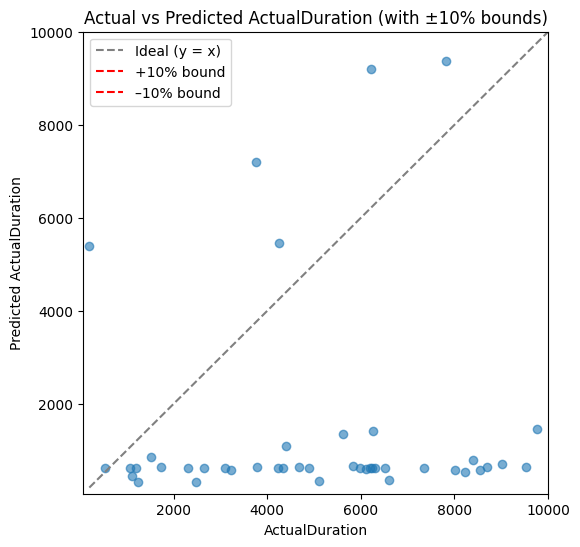

In [51]:
# Visualization of results
import matplotlib.pyplot as plt

# scatter Actual vs Predicted
# true values ==> y_test,  predictions ==> y_pred
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)

# Determine plotting limits based on the actual durations
min_val = y_test.min()
max_val = y_test.max()
lims    = [min_val, max_val]

# Plot the 45 degree line
plt.plot(lims, lims, '--', color='gray', label='Ideal (y = x)')

# Compute a constant offset for ±10% of the span
delta = 0.10 * (max_val - min_val)

# Simply set lims yourself:
lims = [70, 10000]

plt.xlim(lims)
plt.ylim(lims)

# Plot parallel ±10% bounds
plt.plot(lims, [l + delta for l in lims], '--', color='red', label='+10% bound')
plt.plot(lims, [l - delta for l in lims], '--', color='red', label='–10% bound')

# Seting axes, labels, title, legend
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("ActualDuration")
plt.ylabel("Predicted ActualDuration")
plt.title("Actual vs Predicted ActualDuration (with ±10% bounds)")
plt.legend()
plt.show()


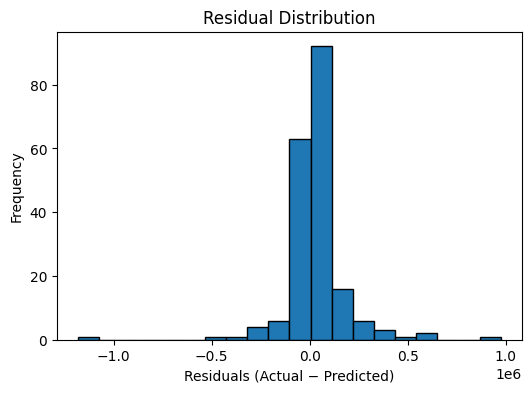

In [52]:
plt.figure(figsize=(6,4))
plt.hist(y_test - y_pred, bins=20, edgecolor='black')
plt.xlabel("Residuals (Actual − Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()

In [53]:
#------------------RNN------------------

In [54]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [55]:
# Load data
df_completed = pd.read_excel("completed.xlsx")
df_inprogress = pd.read_excel("inprogress.xlsx")

features = ["Budget", "EstimatedCost", "ActualDuration"]
target = "ActualCost"

X_completed = df_completed[features].values
y_completed = df_completed[target].values
X_inprog = df_inprogress[features].values


In [56]:
from sklearn.model_selection import train_test_split

# Randomly split completed data into training (80%) and validation (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X_completed,        # features
    y_completed,        # target
    test_size=0.2,      # 20% validation
    random_state=42,    # for reproducibility
    shuffle=True        # random shuffle before splitting
)

print(f"Train samples: {X_train.shape[0]}, Validation samples: {X_test.shape[0]}")


Train samples: 787, Validation samples: 197


In [57]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_inprog_scaled = scaler.transform(X_inprog)


In [58]:
# Reshape for RNN input: (samples, timesteps, features)
# Here timesteps=3 (each feature is a timestep), features=1 (single value per timestep)
X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
X_inprog_rnn = X_inprog_scaled.reshape((X_inprog_scaled.shape[0], X_inprog_scaled.shape[1], 1))


In [59]:
# Build RNN model
model = Sequential([
    SimpleRNN(64, activation='relu', input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,337 (24.75 KB)

 Trainable params: 6,337 (24.75 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# Train with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_rnn, y_train,
    validation_data=(X_test_rnn, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 77704511488.0000 - mae: 191340.9219 - val_loss: 132467523584.0000 - val_mae: 221442.6250
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 78718328832.0000 - mae: 194969.5469 - val_loss: 132450942976.0000 - val_mae: 221429.1406
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 73092956160.0000 - mae: 186891.7500 - val_loss: 132334944256.0000 - val_mae: 221327.9844
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 75781660672.0000 - mae: 190669.9375 - val_loss: 131739435008.0000 - val_mae: 220801.0156
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 74431193088.0000 - mae: 186908.9688 - val_loss: 129620197376.0000 - val_mae: 218886.1562
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 71374430208.0000 - mae: 183158.7969 - val_loss: 123907489792.0000 - val_mae: 213698.8594
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 70611214336.0000 - mae: 181243.0312 - val_loss: 11120

In [61]:
# Evaluate on validation set
y_pred = model.predict(X_test_rnn).flatten()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"Validation MSE: {mse:.2f}")
print(f"Validation MAE: {mae:.2f}")
print(f"Validation MAPE: {mape:.2f}%")
print(f"Validation R²: {r2:.3f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Validation MSE: 30756896768.00
Validation MAE: 133024.12
Validation MAPE: 1008.60%
Validation R²: 0.631


In [62]:
#-------------KNN----------------

In [63]:
# Step 1: Imports
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [64]:
# Step 2: Load data and select features and target
df_completed = pd.read_excel("completed.xlsx")
df_inprogress = pd.read_excel("inprogress.xlsx")

features = ["Budget", "EstimatedCost", "ActualDuration"]
target = "ActualCost"

X = df_completed[features].values
y = df_completed[target].values

X_inprog = df_inprogress[features].values


In [65]:
# Step 3: Random train-test split (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"Train samples: {X_train.shape[0]}, Validation samples: {X_test.shape[0]}")


Train samples: 787, Validation samples: 197


In [66]:
# Step 4: Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_inprog_scaled = scaler.transform(X_inprog)


In [67]:
# Step 5: Instantiate and train KNN regressor
knn = KNeighborsRegressor(n_neighbors=5)  # you can tune n_neighbors later
knn.fit(X_train_scaled, y_train)

print("KNN trained on training data")


KNN trained on training data


In [68]:
# Step 6: Predict and evaluate on validation set
y_pred = knn.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"Validation MSE: {mse:.2f}")
print(f"Validation MAE: {mae:.2f}")
print(f"Validation MAPE: {mape:.2f}%")
print(f"Validation R²: {r2:.3f}")


Validation MSE: 44590858432.41
Validation MAE: 77245.65
Validation MAPE: 197.85%
Validation R²: 0.466


In [69]:
#------------------Light GBM

In [70]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm import LGBMRegressor


In [71]:
# Step 2: Load data and select features and target
df_completed = pd.read_excel("completed.xlsx")
df_inprogress = pd.read_excel("inprogress.xlsx")

features = ["Budget", "EstimatedCost", "ActualDuration"]
target = "ActualCost"

X = df_completed[features].values
y = df_completed[target].values

X_inprog = df_inprogress[features].values


In [72]:
# Step 3: Random train-test split (80% train, 20% validation)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"Train samples: {X_train.shape[0]}, Validation samples: {X_test.shape[0]}")


Train samples: 787, Validation samples: 197


In [73]:
# Step 4: Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_inprog_scaled = scaler.transform(X_inprog)


In [74]:
# Step 5: Instantiate and train LightGBM regressor
lgbm = LGBMRegressor(random_state=42, n_estimators=100, max_depth=5, learning_rate=0.1)
lgbm.fit(X_train_scaled, y_train)

print("LightGBM trained on training data")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 668
[LightGBM] [Info] Number of data points in the train set: 787, number of used features: 3
[LightGBM] [Info] Start training from score 187368.365947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [75]:
# Step 6: Predict and evaluate on validation set
y_pred = lgbm.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"Validation MSE: {mse:.2f}")
print(f"Validation MAE: {mae:.2f}")
print(f"Validation MAPE: {mape:.2f}%")
print(f"Validation R²: {r2:.3f}")


Validation MSE: 42165432364.78
Validation MAE: 69710.60
Validation MAPE: 201.85%
Validation R²: 0.495


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [76]:
# Step 1: Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor


In [77]:
# Step 2: Load data and select features and target
df_completed = pd.read_excel("completed.xlsx")
df_inprogress = pd.read_excel("inprogress.xlsx")

features = ["Budget", "EstimatedCost", "ActualDuration"]
target = "ActualCost"

X = df_completed[features].values
y = df_completed[target].values

X_inprog = df_inprogress[features].values


In [78]:
# Step 3: Random train-test split (80% train, 20% validation)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"Train samples: {X_train.shape[0]}, Validation samples: {X_test.shape[0]}")


Train samples: 787, Validation samples: 197


In [79]:
# Step 3: Random train-test split (80% train, 20% validation)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"Train samples: {X_train.shape[0]}, Validation samples: {X_test.shape[0]}")


Train samples: 787, Validation samples: 197


In [80]:
# Step 4: (Optional) Feature scaling — CatBoost can handle raw data, so this is optional
# But if you want consistency with other models, you can scale features:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_inprog_scaled = scaler.transform(X_inprog)


In [81]:
# Step 5: Instantiate and train CatBoost regressor
cat_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=100
)

# Use scaled or raw features accordingly:
cat_model.fit(X_train_scaled, y_train, eval_set=(X_test_scaled, y_test), early_stopping_rounds=20)


0:	learn: 185203.9661491	test: 281236.7103363	best: 281236.7103363 (0)	total: 150ms	remaining: 1m 14s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 200863.4973
bestIteration = 71

Shrink model to first 72 iterations.


In [82]:
# Step 6: Predict and evaluate on validation set
y_pred = cat_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"Validation MSE: {mse:.2f}")
print(f"Validation MAE: {mae:.2f}")
print(f"Validation MAPE: {mape:.2f}%")
print(f"Validation R²: {r2:.3f}")


Validation MSE: 40346144554.31
Validation MAE: 67883.58
Validation MAPE: 230.47%
Validation R²: 0.516


In [83]:
#------------------Dropout MLP

In [84]:
# Step 1: Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [85]:
# Step 2: Load data and select features and target
df_completed = pd.read_excel("completed.xlsx")
df_inprogress = pd.read_excel("inprogress.xlsx")

features = ["Budget", "EstimatedCost", "ActualDuration"]
target = "ActualCost"

X = df_completed[features].values
y = df_completed[target].values
X_inprog = df_inprogress[features].values


In [86]:
# Step 3: Random train-test split (80% train, 20% validation)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"Train samples: {X_train.shape[0]}, Validation samples: {X_test.shape[0]}")


Train samples: 787, Validation samples: 197


In [87]:
# Step 4: Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_inprog_scaled = scaler.transform(X_inprog)


In [88]:
# Step 5: Build Dropout MLP model
def build_dropout_mlp():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1))  # output layer for regression
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_dropout_mlp()
model.summary()


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,833 (34.50 KB)

 Trainable params: 8,833 (34.50 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
# Step 6: Train model with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 75474378752.0000 - mae: 188820.2969 - val_loss: 132467564544.0000 - val_mae: 221442.2500
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 72310480896.0000 - mae: 182762.2656 - val_loss: 132462092288.0000 - val_mae: 221437.3125
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 76566568960.0000 - mae: 188411.0781 - val_loss: 132449009664.0000 - val_mae: 221425.9062
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 69809463296.0000 - mae: 179447.6094 - val_loss: 132421902336.0000 - val_mae: 221403.3906
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 69850177536.0000 - mae: 181218.0781 - val_loss: 132370849792.0000 - val_mae: 221362.7031
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 73902096384.0000 - mae: 189824.5469 - val_loss: 132286144512.0000 - val_mae: 221297.4219
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 75304075264.0000 - mae: 186020.7031 - val_loss: 13215

In [90]:
# Step 7: Evaluate on validation set
y_pred = model.predict(X_test_scaled).flatten()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"Validation MSE: {mse:.2f}")
print(f"Validation MAE: {mae:.2f}")
print(f"Validation MAPE: {mape:.2f}%")
print(f"Validation R²: {r2:.3f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Validation MSE: 35486347264.00
Validation MAE: 124432.08
Validation MAPE: 483.67%
Validation R²: 0.575


In [91]:
#-----------CNN-----------

In [92]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [93]:
# Load and prepare data
df_completed = pd.read_excel("completed.xlsx")
df_inprogress = pd.read_excel("inprogress.xlsx")

features = ["Budget", "EstimatedCost", "ActualDuration"]
target = "ActualCost"

X = df_completed[features].values
y = df_completed[target].values
X_inprog = df_inprogress[features].values


In [94]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)


In [95]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_inprog_scaled = scaler.transform(X_inprog)


In [96]:
# Reshape for Conv1D: (samples, timesteps, features)
# Treat features as timesteps, each timestep has 1 feature
X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
X_inprog_cnn = X_inprog_scaled.reshape((X_inprog_scaled.shape[0], X_inprog_scaled.shape[1], 1))


In [97]:
# Build CNN model
model = Sequential([
    Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2, 32)          │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,321 (16.88 KB)

 Trainable params: 4,321 (16.88 KB)

 Non-trainable params: 0 (0.00 B)

In [98]:
# Train model with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_cnn, y_train,
    validation_data=(X_test_cnn, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 75916845056.0000 - mae: 185346.5781 - val_loss: 132469383168.0000 - val_mae: 221443.6562
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 67276009472.0000 - mae: 174953.1562 - val_loss: 132467531776.0000 - val_mae: 221441.5000
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 65407447040.0000 - mae: 172733.4688 - val_loss: 132463312896.0000 - val_mae: 221436.7500
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 73338601472.0000 - mae: 186139.0000 - val_loss: 132455047168.0000 - val_mae: 221427.8438
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 78595465216.0000 - mae: 189755.5469 - val_loss: 132440645632.0000 - val_mae: 221412.8750
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 72611610624.0000 - mae: 181444.4844 - val_loss: 132416634880.0000 - val_mae: 221389.2031
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 77044105216.0000 - mae: 194039.4375 - val_loss: 13237

In [99]:
# Evaluate
y_pred = model.predict(X_test_cnn).flatten()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"Validation MSE: {mse:.2f}")
print(f"Validation MAE: {mae:.2f}")
print(f"Validation MAPE: {mape:.2f}%")
print(f"Validation R²: {r2:.3f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Validation MSE: 36390367232.00
Validation MAE: 130147.59
Validation MAPE: 395.16%
Validation R²: 0.564
